# 自定义数据集上的模型微调训练

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/resource/_static/logo_notebook.png)](https://github.com/mindlab-ai/mindcv/blob/main/tutorials/finetune.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/resource/_static/logo_download_code.png)](https://github.com/mindlab-ai/mindcv/blob/main/examples/finetune.py)&emsp;

在此教程中，您将学会如何使用MindCV套件进行迁移学习，以解决自定义数据集上的图像分类问题。在深度学习任务中，常见遇到训练数据不足的问题，此时直接训练整个网络往往难以达到理想的精度。一个比较好的做法是，使用一个在大规模数据集上(与任务数据较为接近)预训练好的模型，然后使用该模型来初始化网络的权重参数或作为固定特征提取器应用于特定的任务中。

此教程将以使用ImageNet上预训练的DenseNet模型为例，介绍两种不同的微调策略，解决小样本情况下狼和狗的图像分类问题: 

1. 整体网络微调。
2. 冻结特征网络(freeze backbone)，只微调分类器。

> 迁移学习详细内容见[Stanford University CS231n](https://cs231n.github.io/transfer-learning/#tf)

## 数据准备

### 下载数据集

下载案例所用到的[狗与狼分类数据集](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/intermediate/Canidae_data.zip)，每个类别各有120张训练图像与30张验证图像。使用`mindcv.utils.download`接口下载数据集，并将下载后的数据集自动解压到当前目录下。

In [1]:
import sys
sys.path.append('../')

from mindcv.utils.download import DownLoad
import os

dataset_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/intermediate/Canidae_data.zip"
root_dir = "./"

if not os.path.exists(os.path.join(root_dir, 'data/Canidae')):
    DownLoad().download_and_extract_archive(dataset_url, root_dir)

数据集的目录结构如下：

```Text
data/
└── Canidae
    ├── train
    │   ├── dogs
    │   └── wolves
    └── val
        ├── dogs
        └── wolves
```

## 数据集加载及处理


### 自定义数据集的加载
通过调用`mindcv.data`中的`create_dataset`函数，我们可轻松地加载预设的数据集以及自定义的数据集。
- 当参数`name`设为空时，指定为自定义数据集。(默认值)
- 当参数`name`设为`MNIST`, `CIFAR10`等标准数据集名称时，指定为预设数据集。

同时，我们需要设定数据集的路经`data_dir`和数据切分的名称`split` (如train, val)，以加载对应的训练集或者验证集。

In [2]:
from mindcv.data import create_dataset, create_transforms, create_loader

num_workers = 8

# 数据集目录路径
data_dir = "./data/Canidae/"

# 加载自定义数据集
dataset_train = create_dataset(root=data_dir, split='train', num_parallel_workers=num_workers)
dataset_val = create_dataset(root=data_dir, split='val', num_parallel_workers=num_workers)

> 注意: 自定义数据集的目录结构应与ImageNet一样，即root -> split -> class -> image 的层次结构 

```Text
DATASET_NAME
    ├── split1(e.g. train)/  
    │  ├── class1/
    │  │   ├── 000001.jpg
    │  │   ├── 000002.jpg
    │  │   └── ....
    │  └── class2/
    │      ├── 000001.jpg
    │      ├── 000002.jpg
    │      └── ....
    └── split2/   
       ├── class1/
       │   ├── 000001.jpg
       │   ├── 000002.jpg
       │   └── ....
       └── class2/
           ├── 000001.jpg
           ├── 000002.jpg
           └── ....
```

### 数据处理及增强

首先我们通过调用`create_transforms`函数, 获得预设的数据处理和增强策略(transform list)，此任务中，因狼狗图像和ImageNet数据一致（即domain一致），我们指定参数`dataset_name`为ImageNet，直接用预设好的ImageNet的数据处理和图像增强策略。`create_transforms` 同样支持多种自定义的处理和增强操作，以及自动增强策略(AutoAug)。详见API说明。 

我们将得到的transform list传入`create_loader()`，并指定`batch_size`和其他参数，即可完成训练和验证数据的准备，返回`Dataset` Object，作为模型的输入。

In [3]:
# 定义和获取数据处理及增强操作
trans_train = create_transforms(dataset_name='ImageNet', is_training=True)
trans_val = create_transforms(dataset_name='ImageNet',is_training=False)

# 
loader_train = create_loader(
        dataset=dataset_train,
        batch_size=16,
        is_training=True,
        num_classes=2,
        transform=trans_train,
        num_parallel_workers=num_workers,
    )
    

loader_val = create_loader(
        dataset=dataset_val,
        batch_size=5,
        is_training=True,
        num_classes=2,
        transform=trans_val,
        num_parallel_workers=num_workers,
    )

### 数据集可视化

对于`create_loader`接口返回的完成数据加载的Dataset object，我们可以通过 `create_tuple_iterator` 接口创建数据迭代器，使用 `next` 迭代访问数据集，读取到一个batch的数据。

In [4]:
images, labels= next(loader_train.create_tuple_iterator())
#images = data["image"]
#labels = data["label"]

print("Tensor of image", images.shape)
print("Labels:", labels)

Tensor of image (16, 3, 224, 224)
Labels: [0 1 1 1 1 0 0 0 0 0 1 0 1 0 1 1]


对获取到的图像及标签数据进行可视化，标题为图像对应的label名称。

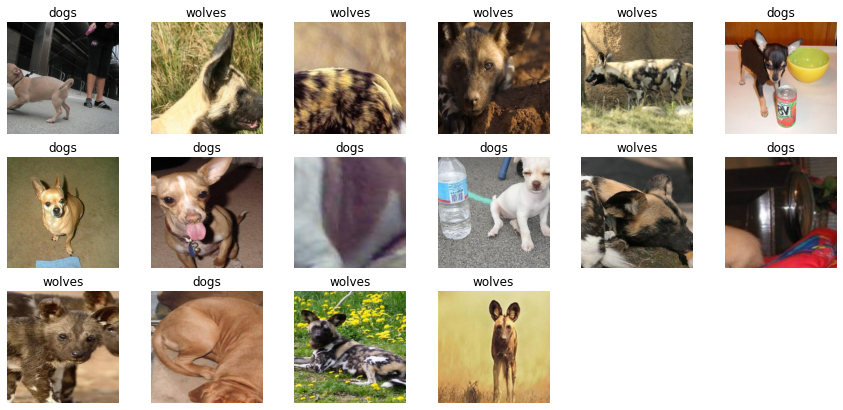

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# class_name对应label，按文件夹字符串从小到大的顺序标记label
class_name = {0: "dogs", 1: "wolves"}

plt.figure(figsize=(15, 7))
for i in range(len(labels)):
    # 获取图像及其对应的label
    data_image = images[i].asnumpy()
    data_label = labels[i]
    # 处理图像供展示使用
    data_image = np.transpose(data_image, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data_image = std * data_image + mean
    data_image = np.clip(data_image, 0, 1)
    # 显示图像
    plt.subplot(3, 6, i + 1)
    plt.imshow(data_image)
    plt.title(class_name[int(labels[i].asnumpy())])
    plt.axis("off")

plt.show()

## 1. 整体模型微调

### 预训练模型加载
我们使用`mindcv.models.densenet`中定义DenseNet121网络，当接口中的`pretrained`参数设置为True时，可以自动下载网络权重。
由于该预训练模型是针对ImageNet数据集中的1000个类别进行分类的，这里我们设定`num_classes=2`, DenseNet的classifier(即最后的FC层)输出调整为两维，此时只加载backbone的预训练权重，而classifier则使用初始值。

In [6]:
from mindcv.models import create_model

network = create_model(model_name='densenet121', num_classes=2, pretrained=True)

[WARNING] ME(116613:140051982694208,MainProcess):2022-09-20-03:44:58.786.568 [mindspore/train/serialization.py:709] For 'load_param_into_net', 2 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(116613:140051982694208,MainProcess):2022-09-20-03:44:58.787.703 [mindspore/train/serialization.py:714] classifier.weight is not loaded.
[WARNING] ME(116613:140051982694208,MainProcess):2022-09-20-03:44:58.788.408 [mindspore/train/serialization.py:714] classifier.bias is not loaded.



> DenseNet的具体结构可参见[DenseNet论文](https://arxiv.org/pdf/1608.06993.pdf)。

### 模型训练

使用已加载处理好的带标签的狼和狗图像，对DenseNet进行微调网络。 
注意，对整体模型做微调时，应使用较小的learning rate。

In [7]:
from mindcv.loss import create_loss
from mindcv.optim import create_optimizer
from mindcv.scheduler import create_scheduler
from mindspore import Model, LossMonitor, TimeMonitor #, CheckpointConfig, ModelCheckpoint


# 定义优化器和损失函数
opt = create_optimizer(network.trainable_params(), opt='adam', lr=1e-4) 
loss = create_loss(name='CE')

# 实例化模型
model = Model(network, loss_fn=loss, optimizer=opt, metrics={'accuracy'}) 

In [8]:
model.train(10, loader_train, callbacks=[LossMonitor(5), TimeMonitor(5)], dataset_sink_mode=False)

epoch: 1 step: 5, loss is 0.5195528864860535
epoch: 1 step: 10, loss is 0.2654373049736023
epoch: 1 step: 15, loss is 0.28758567571640015
Train epoch time: 17270.144 ms, per step time: 1151.343 ms
epoch: 2 step: 5, loss is 0.1807008981704712
epoch: 2 step: 10, loss is 0.1700802594423294
epoch: 2 step: 15, loss is 0.09752683341503143
Train epoch time: 1372.549 ms, per step time: 91.503 ms
epoch: 3 step: 5, loss is 0.13594701886177063
epoch: 3 step: 10, loss is 0.03628234937787056
epoch: 3 step: 15, loss is 0.039737217128276825
Train epoch time: 1453.237 ms, per step time: 96.882 ms
epoch: 4 step: 5, loss is 0.014213413000106812
epoch: 4 step: 10, loss is 0.030747078359127045
epoch: 4 step: 15, loss is 0.0798817127943039
Train epoch time: 1331.237 ms, per step time: 88.749 ms
epoch: 5 step: 5, loss is 0.009510636329650879
epoch: 5 step: 10, loss is 0.02603740245103836
epoch: 5 step: 15, loss is 0.051846928894519806
Train epoch time: 1312.737 ms, per step time: 87.516 ms
epoch: 6 step: 5,

### 模型评估

在训练完成后，我们在验证集上评估模型的精度。

In [9]:
res = model.eval(loader_val)
print(res)

{'accuracy': 1.0}


#### 可视化模型推理结果

定义 `visualize_mode` 函数，可视化模型预测。

In [10]:
import matplotlib.pyplot as plt
import mindspore as ms

def visualize_model(model, val_dl, num_classes=2):
    # 加载验证集的数据进行验证
    images, labels= next(val_dl.create_tuple_iterator())
    # 预测图像类别
    output = model.predict(images)
    pred = np.argmax(output.asnumpy(), axis=1)
    # 显示图像及图像的预测值
    images = images.asnumpy()
    labels = labels.asnumpy()
    class_name = {0: "dogs", 1: "wolves"}
    plt.figure(figsize=(15, 7))
    for i in range(len(labels)):
        plt.subplot(3, 6, i + 1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('predict:{}'.format(class_name[pred[i]]), color=color)
        picture_show = np.transpose(images[i], (1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()

使用微调过后的模型件对验证集的狼和狗图像数据进行预测。若预测字体为蓝色表示预测正确，若预测字体为红色表示预测错误。

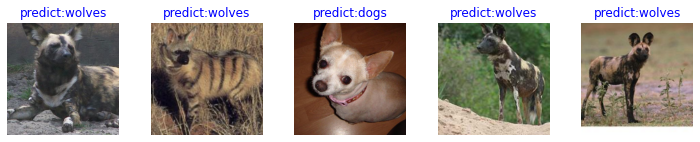

In [11]:
visualize_model(model, loader_val)

## 2. 冻结特征网络, 微调分类器

### 冻结特征网络的参数

首先，我们要冻结除最后一层分类器之外的所有网络层，即将相应的层参数的`requires_grad`属性设置为`False`，使其不在反向传播中计算梯度及更新参数。

因为`mindcv.models` 中所有的模型均以`classifier` 来标识和命名模型的分类器(即Dense层)，所以通过 `classifier.weight` 和 `classifier.bias` 即可筛选出分类器外的各层参数，将其`requires_grad`属性设置为`False`. 

In [12]:
# freeze backbone
for param in network.get_parameters():
    if param.name not in ["classifier.weight", "classifier.bias"]:
        param.requires_grad = False

### 微调分类器
因为特征网络已经固定，我们不必担心训练过程会distort pratrained features，因此，相比于第一种方法，我们可以将learning rate调大一些。

与没有预训练模型相比，将节约一大半时间，因为此时可以不用计算部分梯度。

In [13]:
# 加载数据集
dataset_train = create_dataset(root=data_dir, split='train', num_parallel_workers=num_workers)
loader_train = create_loader(
        dataset=dataset_train,
        batch_size=16,
        is_training=True,
        num_classes=2,
        transform=trans_train,
        num_parallel_workers=num_workers,
    )

# 定义优化器和损失函数
opt = create_optimizer(network.trainable_params(), opt='adam', lr=1e-3) 
loss = create_loss(name='CE')

# 实例化模型
model = Model(network, loss_fn=loss, optimizer=opt, metrics={'accuracy'}) 

model.train(10, loader_train, callbacks=[LossMonitor(5), TimeMonitor(5)], dataset_sink_mode=False)

epoch: 1 step: 5, loss is 0.051333948969841
epoch: 1 step: 10, loss is 0.02043312042951584
epoch: 1 step: 15, loss is 0.16161368787288666
Train epoch time: 10228.601 ms, per step time: 681.907 ms
epoch: 2 step: 5, loss is 0.002121545374393463
epoch: 2 step: 10, loss is 0.0009798109531402588
epoch: 2 step: 15, loss is 0.015776708722114563
Train epoch time: 562.543 ms, per step time: 37.503 ms
epoch: 3 step: 5, loss is 0.008056879043579102
epoch: 3 step: 10, loss is 0.0009347647428512573
epoch: 3 step: 15, loss is 0.028648357838392258
Train epoch time: 523.249 ms, per step time: 34.883 ms
epoch: 4 step: 5, loss is 0.001014217734336853
epoch: 4 step: 10, loss is 0.0003159046173095703
epoch: 4 step: 15, loss is 0.0007699579000473022
Train epoch time: 508.886 ms, per step time: 33.926 ms
epoch: 5 step: 5, loss is 0.0015687644481658936
epoch: 5 step: 10, loss is 0.012090332806110382
epoch: 5 step: 15, loss is 0.004598274827003479
Train epoch time: 507.243 ms, per step time: 33.816 ms
epoch: 

In [14]:
dataset_val = create_dataset(root=data_dir, split='val', num_parallel_workers=num_workers)
loader_val = create_loader(
        dataset=dataset_val,
        batch_size=5,
        is_training=True,
        num_classes=2,
        transform=trans_val,
        num_parallel_workers=num_workers,
    )

res = model.eval(loader_val)
print(res)

{'accuracy': 1.0}


#### 可视化模型预测

使用微调过后的模型件对验证集的狼和狗图像数据进行预测。若预测字体为蓝色表示预测正确，若预测字体为红色表示预测错误。

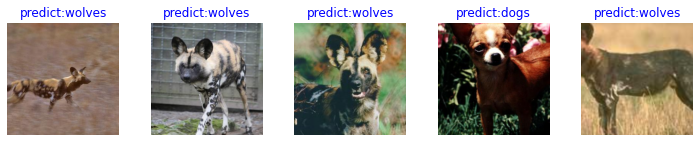

In [15]:
visualize_model(model, loader_val)

微调后的狼狗预测结果均正确